# GBT Meta-Learner

Here we consider gradient boosted trees in a one vs rest framework as a meta-learner on the output from three neural networks combined with all available categorical data. We begin with setup and imports, apologies again for the wall of imports. 

In [1]:
from pyspark.sql import SparkSession

#run me on the DS5110 kernel if running on Rivanna!

#Build spark session, unable to get more than 8 cores for the second half of the semester
#This configuration performs relatively well given that constraint. This application definitely wants more cores though. 
spark = SparkSession \
    .builder\
    .config("spark.executor.memory", '14g') \
    .config("spark.executor.instances", "3") \
    .config('spark.executor.cores', '2') \
    .config("spark.driver.memory",'14g') \
    .config("spark.driver.maxResultSize", "6g")\
    .getOrCreate()

sc = spark.sparkContext


In [5]:
#Give me the modules and no one gets hurt
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.ml.feature import VectorAssembler
import pandas as pd
import numpy as np
from pyspark.sql.functions import col, pandas_udf, PandasUDFType
import os
from pyspark.sql.functions import udf
from pyspark.sql.types import StructType, StructField, IntegerType, FloatType, StringType
import re

from pyspark.ml.classification import GBTClassifier
from spark_tensorflow_distributor import MirroredStrategyRunner
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import *
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.mllib.evaluation import MulticlassMetrics
from sklearn.metrics import ConfusionMatrixDisplay
from pyspark.ml.feature import OneHotEncoder

# Read in pre-featurized images
Here we read in pre-featurized images from the parquet saved in the image featurization notebook. 

In [3]:
data = spark.read.parquet("clean_features.parquet2").na.drop('any')
data.show(5)

+------------+-----------+------------+---+---------+----+------+---------------+--------------------+--------------------+--------------------+
|          ID|  lesion_id|    image_id| dx|  dx_type| age|   sex|   localization|            mnet_vec|             r50_vec|            xcep_vec|
+------------+-----------+------------+---+---------+----+------+---------------+--------------------+--------------------+--------------------+
|ISIC_0024306|HAM_0000550|ISIC_0024306| nv|follow_up|45.0|  male|          trunk|[0.0,0.0,0.0,0.0,...|[0.24354705214500...|[0.0,0.0,0.0,0.0,...|
|ISIC_0024387|HAM_0004156|ISIC_0024387| nv|    histo|65.0|female|lower extremity|[0.0,1.3627424240...|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|
|ISIC_0024397|HAM_0001501|ISIC_0024397| nv|follow_up|65.0|  male|          trunk|[0.0,0.0,0.0,0.0,...|[1.18369388580322...|[0.0,0.0,0.0,0.0,...|
|ISIC_0024551|HAM_0002629|ISIC_0024551| nv|follow_up|50.0|  male|        abdomen|[0.0,0.0,0.0,0.0,...|[0.01115676853805...|[0.0,0.

# Define Pipeline
We one hot encode sex and location and combine it with age and the neural network derived features. 

In [17]:
#Define preprocessing pipeline

#index our response variable
label_index = StringIndexer(inputCol = 'dx', outputCol = 'indexed_dx')

#Index the two categorical variables that we have
label_sex = StringIndexer(inputCol = 'sex', outputCol = 'indexed_sex')
loc_index = StringIndexer(inputCol = 'localization', outputCol = 'indexed_loc')

#OneHot encode variables
OH = OneHotEncoder(inputCols = ['indexed_sex', 'indexed_loc'], outputCols = ['OH_sex', 'OH_loc'])

#Assemble Features vector
vec_assemb = VectorAssembler(inputCols = ['age', 'OH_sex', 'OH_loc', 'mnet_vec', 'r50_vec', 'xcep_vec'], \
                             outputCol = 'Feature_vec', handleInvalid = 'skip')

#vec_index = VectorIndexer(inputCol = 'Feature_vec', outputCol = 'indexed_features', maxCategories = 8, handleInvalid = 'skip')


gbt = GBTClassifier(labelCol="indexed_dx", featuresCol="Feature_vec", maxIter=10, maxDepth=5, maxBins=32)
ovr  = OneVsRest(classifier=gbt,  featuresCol='Feature_vec', labelCol='indexed_dx')

pipe = Pipeline(stages = [label_index, label_sex, loc_index, OH, vec_assemb, ovr])

# Cross Validation

We perform 5 fold cross validation and search across maximum number of bins and maximum tree depth. 

In [17]:
#Setup parameter grid
paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [5, 10, 15]) # Max Depth of trees
             .addGrid(gbt.maxBins, [8,16 ,32]) # Max binning for numeric features
             .build())

In [18]:
#Setup 5 fold cross validation
cv = CrossValidator(estimator=pipe, \
                    estimatorParamMaps=paramGrid, \
                    evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="indexed_dx"), \
                    numFolds=5, \
                    parallelism = 4,\
                    seed = 314)

# Split training and test data

We opt for a stratified 80-20 split due to the presence of small minority classes in the problem. True random splitting risks leaving one set with too few samples. 

In [7]:
#Define Fractions for training and test split
training_frac = {'vasc': 0.8,
 'nv': 0.8,
 'mel': 0.8,
 'bcc': 0.8,
 'df': 0.8,
 'bkl': 0.8,
 'akiec': 0.8}

In [8]:
#Stratified sample
train = data.sampleBy('dx', training_frac, seed = 314)
#cache for performance
train.cache()

DataFrame[ID: string, lesion_id: string, image_id: string, dx: string, dx_type: string, age: double, sex: string, localization: string, mnet_vec: vector, r50_vec: vector, xcep_vec: vector]

In [9]:
#Define the test set, just subtract train from the remainder of the data
test = data.subtract(train)


# Fit and evaluate the model

We perform cross validation and examine performance on the training set. We look at overall metrics and specifically at melanoma as the most malignant disorder in the dataset. It is of particular interest to classify this one accurately. 

In [22]:
#Call our CV model to fit on the training set
cvModel = cv.fit(train)

In [28]:
#Save the model because this thing is slow as heck
best_model = cvModel.bestModel
best_model.write().overwrite().save('GBT_Model')

In [4]:
from pyspark.ml.pipeline import PipelineModel
persistedModel = PipelineModel.load('GBT_Model')

In [ ]:
#Evaluate performance on the validation set
results = cvModel.bestModel.transform(test)

In [11]:
#Evaluate performance on the validation set
results = persistedModel.transform(test)

In [34]:
preds_and_labels.cache()

DataFrame[prediction: double, label: float]

In [48]:
pl = spark.read.csv('preds_labels', inferSchema = True)
preds_and_labels.rdd.map(tuple)

In [14]:
#Subset predictions in order to map to RDD, we prefer mllibs classification evasluator
preds_and_labels = results.select(['prediction','indexed_dx']).withColumn('label', col('indexed_dx').cast(FloatType()))

#select only prediction and label columns
preds_and_labels = preds_and_labels.select(['prediction','label'])

metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))

print(metrics.confusionMatrix().toArray())

[[1.278e+03 4.100e+01 2.300e+01 7.000e+00 2.000e+00 3.000e+00 2.000e+00]
 [8.100e+01 9.300e+01 2.300e+01 6.000e+00 3.000e+00 0.000e+00 0.000e+00]
 [4.700e+01 2.900e+01 1.200e+02 1.100e+01 9.000e+00 1.000e+00 0.000e+00]
 [1.300e+01 1.100e+01 1.300e+01 6.500e+01 1.000e+00 2.000e+00 2.000e+00]
 [6.000e+00 8.000e+00 2.600e+01 1.200e+01 1.600e+01 0.000e+00 1.000e+00]
 [4.000e+00 0.000e+00 0.000e+00 2.000e+00 0.000e+00 1.600e+01 0.000e+00]
 [9.000e+00 3.000e+00 2.000e+00 2.000e+00 0.000e+00 0.000e+00 7.000e+00]]


In [51]:
#Subset predictions in order to map to RDD, we prefer mllibs classification evasluator
preds_and_labels = results.select(['prediction','indexed_dx']).withColumn('label', col('indexed_dx').cast(FloatType()))

#select only prediction and label columns
preds_and_labels = preds_and_labels.select(['prediction','label'])

metrics = MulticlassMetrics(pl)

print(metrics.confusionMatrix().toArray())

[[1.278e+03 4.100e+01 2.300e+01 7.000e+00 2.000e+00 3.000e+00 2.000e+00]
 [8.100e+01 9.300e+01 2.300e+01 6.000e+00 3.000e+00 0.000e+00 0.000e+00]
 [4.700e+01 2.900e+01 1.200e+02 1.100e+01 9.000e+00 1.000e+00 0.000e+00]
 [1.300e+01 1.100e+01 1.300e+01 6.500e+01 1.000e+00 2.000e+00 2.000e+00]
 [6.000e+00 8.000e+00 2.600e+01 1.200e+01 1.600e+01 0.000e+00 1.000e+00]
 [4.000e+00 0.000e+00 0.000e+00 2.000e+00 0.000e+00 1.600e+01 0.000e+00]
 [9.000e+00 3.000e+00 2.000e+00 2.000e+00 0.000e+00 0.000e+00 7.000e+00]]


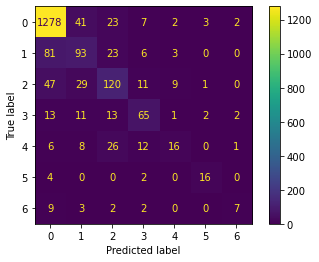

In [15]:
#ok, that's heinously ugly. It's not spark, but this looks more presentable
%matplotlib inline
ConfusionMatrixDisplay(metrics.confusionMatrix().toArray().astype(int)).plot()

In [53]:
#Define some weighted model metrics
weighted_recall =  metrics.weightedRecall
weighted_precision =  metrics.weightedPrecision
weighted_f1 = metrics.weightedFMeasure(beta = 1.0)
weighted_fpr =  metrics.weightedFalsePositiveRate
accuracy = metrics.accuracy

In [54]:
#Don't kill me, the pandas dataframe is just so it looks nicer in the notebook
values = [weighted_recall, weighted_precision, weighted_f1, weighted_fpr, accuracy]
index = ['recall', 'precision', 'F1 score', 'FPR', 'accuracy']

pd.DataFrame(values, index = index, columns = ['Metric Value'])

,Metric Value
recall,0.797500
precision,0.782873
F1 score,0.787105
FPR,0.180484
accuracy,0.797500


In [62]:
#Get Parameters for best model 
bestModel = cvModel.bestModel
max_depth = bestModel.stages[5].getClassifier().getMaxDepth()
max_bins = bestModel.stages[5].getClassifier().getMaxBins()

values = [max_depth, max_bins]
index = ['max depth', 'max bins']

pd.DataFrame(values, index = index, columns = ['Hyperparameter Value'])

,Hyperparameter Value
max depth,5
max bins,32


In [8]:
#Define Fractions for training and test split
training_frac = {'vasc': 0.8*.8,
 'nv': 0.8 *.017,
 'mel': 0.8*.1,
 'bcc': 0.8 * .22,
 'df': 0.8 ,
 'bkl': 0.8 * .1,
 'akiec': 0.33*.8}

In [9]:
#Stratified sample
train = data.sampleBy('dx', training_frac, seed = 314)
#cache for performance
train.cache()

DataFrame[ID: string, lesion_id: string, image_id: string, dx: string, dx_type: string, age: double, sex: string, localization: string, mnet_vec: vector, r50_vec: vector, xcep_vec: vector]

In [10]:
test = data.subtract(train)

In [18]:
gbt_undersample = pipe.fit(train)

In [19]:
results = gbt_undersample.transform(test)

In [20]:
#Subset predictions in order to map to RDD, we prefer mllibs classification evasluator
preds_and_labels = results.select(['prediction','indexed_dx']).withColumn('label', col('indexed_dx').cast(FloatType()))

#select only prediction and label columns
preds_and_labels = preds_and_labels.select(['prediction','label'])

metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))

print(metrics.confusionMatrix().toArray())

[[1.950e+02 2.400e+01 5.100e+01 2.900e+01 1.300e+01 6.800e+01 3.500e+01]
 [3.000e+00 3.700e+01 0.000e+00 3.000e+00 1.000e+00 1.000e+00 1.000e+00]
 [2.000e+00 1.000e+00 1.000e+01 2.000e+00 2.000e+00 3.000e+00 3.000e+00]
 [1.140e+02 2.800e+01 6.600e+01 4.730e+02 6.700e+01 1.160e+02 1.380e+02]
 [3.110e+02 3.320e+02 4.960e+02 6.580e+02 3.868e+03 1.370e+02 7.760e+02]
 [4.900e+01 8.000e+00 2.500e+01 4.100e+01 9.000e+00 1.000e+02 1.500e+01]
 [7.000e+01 6.000e+01 5.000e+01 1.600e+02 9.700e+01 9.000e+01 5.060e+02]]


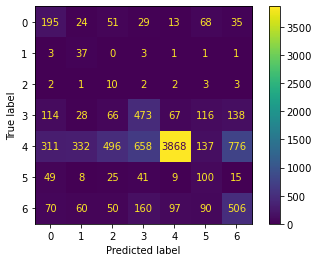

In [21]:
#ok, that's heinously ugly. It's not spark, but this looks more presentable
%matplotlib inline
ConfusionMatrixDisplay(metrics.confusionMatrix().toArray().astype(int)).plot()

In [23]:
#Define some weighted model metrics
weighted_recall =  metrics.weightedRecall
weighted_precision =  metrics.weightedPrecision
weighted_f1 = metrics.weightedFMeasure(beta = 1.0)
weighted_fpr =  metrics.weightedFalsePositiveRate
accuracy = metrics.accuracy

In [24]:
#Don't kill me, the pandas dataframe is just so it looks nicer in the notebook
values = [weighted_recall, weighted_precision, weighted_f1, weighted_fpr, accuracy]
index = ['recall', 'precision', 'F1 score', 'FPR', 'accuracy']

pd.DataFrame(values, index = index, columns = ['Metric Value'])

,Metric Value
recall,0.555330
precision,0.763448
F1 score,0.622180
FPR,0.076817
accuracy,0.555330


In [25]:
labels = [0.0,1.0,2.0,3.0,4.0,5.0,6.0]
cv_df = pd.DataFrame()
for label in sorted(labels):
    cv_df = cv_df.append({"class": label, 
               "precision":metrics.precision(label),
               "recall":metrics.recall(label),
               "f1":metrics.fMeasure(label),
              }, ignore_index=True)
cv_df

,class,f1,precision,recall
0,0.0,0.336497,0.262097,0.469880
1,1.0,0.138060,0.075510,0.804348
2,2.0,0.027739,0.014327,0.434783
3,3.0,0.399493,0.346266,0.472056
4,4.0,0.727409,0.953414,0.588021
5,5.0,0.262467,0.194175,0.404858
6,6.0,0.403670,0.343284,0.489835
